<a href="https://colab.research.google.com/github/arvynathaniel/Python/blob/main/Credit_Score_Classification_Data_Cleaning_(Test_Dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Cleaning Project: Credit Score Classification Test Dataset**

In this project, we will be doing some data cleaning and feature engineering to the testing dataset about a credit score classification. The product of this project is a csv file that can further be used in a prediction project to classify clients' credit score. Previously, we have done the data cleaning and feature engineering for the training dataset. In the current project, the principle is to do mainly the same steps for the testing dataset data cleaning and feature engineering as we did with the testing dataset. However, due to the possibility of some different natures between the two datasets, we will still be looking at and learning about the testing dataset, finding out its differences from the training dataset, then make some tweaks to the data cleaning and feature engineering steps to better fit with the testing dataset.

Our thanks to the provider of the original datasets:
https://www.kaggle.com/datasets/parisrohan/credit-score-classification

## **I. Project Preparation**

### **Ia. Libraries**

In [1]:
# importing libraries
import pandas as pd

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

import sys
!{sys.executable} -m pip install termcolor

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

from termcolor import colored

import warnings
warnings.filterwarnings("ignore") 
warnings.warn("this will not show")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### **Ib. Datasets**

In [2]:
# original test dataset to serve as reset checkpoint
test_ori = pd.read_csv('test.csv')

# copy of test dataset
test = test_ori.copy()

### **Ic. Functions**

In [3]:
# Function to get count of each unique value in a feature and its portion
def uniquevalueprob(dataset, feature, excludeditem = None):
    # Storing each unique value in a list
    global listUV
    listUV = list(dataset[feature].unique())
    listUV = [i for i in listUV if type(i) is not float]
    if excludeditem is not None:
        listUV.remove(excludeditem)
    else:
        listUV = listUV
    
    #Storing the count of each unique value in a list
    global listUVcount
    listUVcount = []
    for UV in listUV:
        UVcount = (dataset[feature] == UV).sum()
        listUVcount.append(UVcount)
    
    # Calculating the sum of all UVcount
    totalcount = sum(listUVcount)
    
    # Calculating the portion of each unique value in the feature
    global listUVportion
    listUVportion = []
    for item in listUVcount:
        UVportion = item / totalcount
        listUVportion.append(UVportion)
    
    # Creating the report table
    table = pd.DataFrame(list(zip(listUV, listUVcount, listUVportion)))
    table.columns = [feature, 'Count', 'Portion']
    
    # Displaying the report table
    print(table.sort_values(['Count', feature], 
                            ascending = [0,1]).to_string(index = False))

def countoutlier(dataset, feature):
    # Setting outlier boundaries
    Q1 = dataset[feature].quantile(0.25)
    Q3 = dataset[feature].quantile(0.75)
    IQR = Q3 - Q1
    UBoundary = Q3 + 1.5 * IQR
    LBoundary = Q1 - 1.5 * IQR
    
    # Counting outliers
    outliercount = 0
    for i in dataset[feature]:
        if i > UBoundary or i < LBoundary:
            outliercount = outliercount + 1
        else:
            pass
    
    # Outlier count report
    print('Outlier count in', feature, ':', outliercount)
    
def omitoutlier(dataset, feature):
    # Setting outlier boundaries
    Q1 = dataset[feature].quantile(0.25)
    Q3 = dataset[feature].quantile(0.75)
    IQR = Q3 - Q1
    UBoundary = Q3 + 1.5 * IQR
    LBoundary = Q1 - 1.5 * IQR
    
    # Creating a new list to omit outliers
    newlist = []
    for i in dataset[feature]:
        if i > UBoundary or i < LBoundary:
            newlist.append(np.nan)
        else:
            newlist.append(i)
    
    # Dropping the outliers in the feature
    dataset[feature] = newlist
    
    # Outliers ommission report
    print(feature, ' data distribution after dropping the outliers : ')
    plt.hist(dataset[feature])
    plt.title(feature + ' Data Distribution')
    plt.xlabel(feature)
    plt.ylabel('Count')
    
def lookupreplacement(dataset, reference, feature):
    # to fillna numerical values in a specific feature on a group of entries
    # using their mode
    
    # Creating a dataframe containing the reference feature and feature to change
    lookup = dataset[[reference, feature]]

    # Returning the feature mode of each reference value
    lookup = lookup.groupby(reference).agg(pd.Series.mode)

    # Replacing the feature value of each reference with each one's Mode
    dataset[feature] = dataset[reference].map(lookup[feature])
    
    # Eliminating any generated list values by using the first member of the list
    newlist = []
    for i in range(len(dataset[feature])):
        # for float type members
        if type(dataset[feature][i]) == np.float64:
            newlist.append(dataset[feature][i])
        # for empty list members
        elif type(dataset[feature][i]) == np.ndarray and len(dataset[feature][i]) == 0:
            newlist.append(np.nan)
        # for non-empty list members
        elif type(dataset[feature][i]) == np.ndarray and len(dataset[feature][i]) != 0:
            newlist.append(dataset[feature][i][1])
    dataset[feature] = newlist
    
    # Reconverting the feature into float
    dataset[feature].astype(float)
    
    # Remaining missing value
    remaining = dataset[feature].isnull().sum()
    print('Remaining', feature, 'missing values :', remaining)
    
def aggregatedfillna(dataset, reference, feature):
    # to randomly fillna numerical values in a specific feature on a group of entries
    # using their mean +- standard deviation
    
    # feature lookup table for remaining misisng values, aggregated by the reference feature
    table = dataset[[reference, feature]]

    # Locating the entries in the feature with empty value
    ref = table.loc[table[feature].isnull(), reference]

    # Getting only the unique references
    ref = ref.unique()

    # Transforming the references with empty feature value into a list
    ref = list(ref)

    # Creating the empty feature list
    fe = []
    for i in range(len(ref)):
        fe.append(np.nan)

    # Creating the feature lookup table
    featureLookup = pd.DataFrame(list(zip(ref, fe)))
    featureLookup.columns = [reference, feature]

    # Mean of the feature
    featureMean = dataset[feature].mean()

    # Standard deviation of the feature
    featureStdDev = dataset[feature].std()

    # Generating the feature value for the feature lookup table
    featureLookup[feature] = featureLookup[feature].fillna(pd.Series(np.random.randint(int(featureMean - featureStdDev), 
                                                                                       int(featureMean + featureStdDev),
                                                                                       size = featureLookup[feature].isnull().sum())))
    
    # Filling in the missing values in the feature in reference to the feature lookup table
    dataset[feature] = dataset[feature].fillna(dataset[reference].map(featureLookup.set_index(reference)[feature]))

    # Checking if there are still missing values in the feature
    remaining = dataset[feature].isnull().sum()
    print('Remaining', feature, 'missing values :', remaining)

## **II. Light Data Exploration**

### **IIa. General overview**

There are some information regarding what each feature of the dataset represents given by the provider of the datasets. These information are very useful for us to better understand the datasets.

* 1. ID: Represents a unique identification of an entry
* 2. Customer_ID: Represents a unique identification of a person
* 3. Month: Represents the month of the year
* 4. Name: Represents the name of a person
* 5. Age: Represents the age of the person
* 6. SSN: Represents the social security number of a person
* 7. Occupation: Represents the occupation of the person
* 8. Annual_Income: Represents the annual income of the person
* 9. Monthly_Inhand_Salary:Represents the monthly base salary of a person
* 10. Num_Bank_Accounts: Represents the number of bank accounts a person holds
* 11. Num_Credit_Card: Represents the number of other credit cards held by a person
* 12. Interest_Rate: Represents the interest rate on credit card
* 13. Num_of_Loan: Represents the number of loans taken from the bank
* 14. Type_of_Loan: Represents the types of loan taken by a person
* 15. Delay_from_due_date: Represents the average number of days delayed from the payment date
* 16. Num_of_Delayed_Payment: Represents the average number of payments delayed by a person
* 17. Changed_Credit_Limit: Represents the percentage change in credit card limit
* 18. Num_Credit_Inquiries: Represents the number of credit card inquiries
* 19. Credit_Mix: Represents the classification of the mix of credits
* 20. Outstanding_Debt: Represents the remaining debt to be paid (in USD)
* 21. Credit_Utilization_Ratio: Represents the utilization ratio of credit card
* 22. Credit_History_Age: Represents the age of credit history of the person
* 23. Payment_of_Min_Amount: Represents whether only the minimum amount was paid by the person
* 24. Total_EMI_per_month: Represents the monthly EMI payments (in USD)
* 25. Amount_invested_monthly: Represents the monthly amount invested by the customer (in USD)
* 26. Payment_Behaviour: Represents the payment behavior of the customer (in USD)
* 27. Monthly_Balance: Represents the monthly balance amount of the customer (in USD)

In [4]:
# first five rows of the dataset
pd.set_option('display.max_columns', None)
test.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,2022.0,Good,809.98,35.030402,22 Years and 9 Months,No,49.574949,236.64268203272135,Low_spent_Small_value_payments,186.26670208571772
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,9,13.27,4.0,Good,809.98,33.053114,22 Years and 10 Months,No,49.574949,21.465380264657146,High_spent_Medium_value_payments,361.44400385378196
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,4,12.27,4.0,Good,809.98,33.811894,NaN,No,49.574949,148.23393788500925,Low_spent_Medium_value_payments,264.67544623342997
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24_,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",4,5,11.27,4.0,Good,809.98,32.430559,23 Years and 0 Months,No,49.574949,39.08251089460281,High_spent_Medium_value_payments,343.82687322383634
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,3037.986667,2,4,6,1,Credit-Builder Loan,3,1,5.42,5.0,Good,605.03,25.926822,27 Years and 3 Months,No,18.816215,39.684018417945296,High_spent_Large_value_payments,485.2984336755923


In [5]:
# dataset shape
print('test dataset entries x features :', test.shape)

test dataset entries x features : (50000, 27)


In [6]:
# data type info
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        50000 non-null  object 
 1   Customer_ID               50000 non-null  object 
 2   Month                     50000 non-null  object 
 3   Name                      44985 non-null  object 
 4   Age                       50000 non-null  object 
 5   SSN                       50000 non-null  object 
 6   Occupation                50000 non-null  object 
 7   Annual_Income             50000 non-null  object 
 8   Monthly_Inhand_Salary     42502 non-null  float64
 9   Num_Bank_Accounts         50000 non-null  int64  
 10  Num_Credit_Card           50000 non-null  int64  
 11  Interest_Rate             50000 non-null  int64  
 12  Num_of_Loan               50000 non-null  object 
 13  Type_of_Loan              44296 non-null  object 
 14  Delay_

In [7]:
# categorical features in test dataset
testCat = []
for i in test.columns:
    if test[i].dtype == 'object':
        testCat.append(i)
testCat

['ID',
 'Customer_ID',
 'Month',
 'Name',
 'Age',
 'SSN',
 'Occupation',
 'Annual_Income',
 'Num_of_Loan',
 'Type_of_Loan',
 'Num_of_Delayed_Payment',
 'Changed_Credit_Limit',
 'Credit_Mix',
 'Outstanding_Debt',
 'Credit_History_Age',
 'Payment_of_Min_Amount',
 'Amount_invested_monthly',
 'Payment_Behaviour',
 'Monthly_Balance']

In [8]:
# numerical features in test dataset
testNum = []
for i in test.columns:
    if test[i].dtype == 'float64':
        testNum.append(i)
    if test[i].dtype == 'int64':
        testNum.append(i)
testNum

['Monthly_Inhand_Salary',
 'Num_Bank_Accounts',
 'Num_Credit_Card',
 'Interest_Rate',
 'Delay_from_due_date',
 'Num_Credit_Inquiries',
 'Credit_Utilization_Ratio',
 'Total_EMI_per_month']

### **IIb. Missing values**

In [9]:
# Calculating the missing values for each feature
MissingValues = test.isnull().sum()

# Turning the previous output into a dataframe format
MissingValues = pd.DataFrame(MissingValues)
MissingValues = MissingValues.reset_index()
MissingValues.columns = ['Feature', 'Count']

# Calculating each feature's missing values percentage
ListMissingVPerc = []
for i in MissingValues['Count']:
    missingperc = i/len(test) * 100 # Total entries = 50000 (from previous step)
    ListMissingVPerc.append(missingperc)
ListMissingVPerc = [round(num, 2) for num in ListMissingVPerc]

# Adding the missing values percentage column to the report
MissingValues['Percentage (%)'] = ListMissingVPerc

# Printing the missing values report
print('Missing values on each feature (test) : ')
print(MissingValues.to_string(index = False))

Missing values on each feature (test) : 
                 Feature  Count  Percentage (%)
                      ID      0            0.00
             Customer_ID      0            0.00
                   Month      0            0.00
                    Name   5015           10.03
                     Age      0            0.00
                     SSN      0            0.00
              Occupation      0            0.00
           Annual_Income      0            0.00
   Monthly_Inhand_Salary   7498           15.00
       Num_Bank_Accounts      0            0.00
         Num_Credit_Card      0            0.00
           Interest_Rate      0            0.00
             Num_of_Loan      0            0.00
            Type_of_Loan   5704           11.41
     Delay_from_due_date      0            0.00
  Num_of_Delayed_Payment   3498            7.00
    Changed_Credit_Limit      0            0.00
    Num_Credit_Inquiries   1035            2.07
              Credit_Mix      0            0.00

### **IIc. Duplicated entries**

In [10]:
# duplicated entires
DuplicatedValues = test.duplicated().sum()
print('Duplicated data (test) : ' + str(DuplicatedValues))

Duplicated data (test) : 0


### **IId. Unique values**

In [11]:
# Getting the feature names in a list
testCols = list(test.columns.values)

# Calculating the number of each feature's unique values
ListUniqueC = []
for i in test.columns:
    UCount = len(test[i].unique())
    ListUniqueC.append(UCount)

# Creating the unique values table
UniqueCTable = pd.DataFrame(list(zip(testCols, ListUniqueC)))
UniqueCTable.columns = ['Feature', 'Unique Values']

# Printing the report
print('Unique values in each feature (test):')
print(UniqueCTable.to_string(index = False))

Unique values in each feature (test):
                 Feature  Unique Values
                      ID          50000
             Customer_ID          12500
                   Month              4
                    Name          10140
                     Age            976
                     SSN          12501
              Occupation             16
           Annual_Income          16121
   Monthly_Inhand_Salary          12794
       Num_Bank_Accounts            540
         Num_Credit_Card            819
           Interest_Rate            945
             Num_of_Loan            263
            Type_of_Loan           6261
     Delay_from_due_date             73
  Num_of_Delayed_Payment            444
    Changed_Credit_Limit           3927
    Num_Credit_Inquiries            751
              Credit_Mix              4
        Outstanding_Debt          12685
Credit_Utilization_Ratio          50000
      Credit_History_Age            400
   Payment_of_Min_Amount              3
  

### **IIe. Findings**

**Some findings from the observations above**:
1.   The shape of the test dataset is (50000 x 27)
<br>
<br>
2.   There are some features which likely have wrong type of data type:
*   'Annual_Income' to float64
*   'Num_of_Loan' to int64
*   'Num_of_Delayed_Payment' to int64
*   'Changed_Credit_Limit' to float64
*   'Outstanding_Debt' to float64
*   'Credit_History_Age' to float64
*   'Amount_invested_monthly' to float64
*   'Monthly_Balance' to float 64
<br>
The data type of these features are currently in categorical type, while the data shown on the first five rows are numerical. We need to change this later.
<br>
<br>
3.  Missing values findings on each feature:
*   'Name'
*   'Monthly_Inhand_Salary'
*   'Type_of_Loan'
*   'Num_of_Delayed_Payment'
*   'Num_Credit_Inquiries'
*   'Credit_History_Age'
*   'Amount_invested_monthly'
*   'Monthly_Balance'
<br>
<br>
4.  There are no duplicated entries.
<br>
<br>
5.  Differences from the previously processed training dataset:
*   The shape of the testing dataset is <50000 x 27>, while the traning dataset is <100000 x 28>
*   The difference in number of entries is due to testing dataset displays the last four months for each customer, while the training dataset displays the first eight months
*   The difference in number of features is due to training dataset has Credit_Score feature as the output feature, while the testing dataset does not have it

**Accounting these differences, we will modify:**
1.  The CustomerIndexer range in the data cleaning process for the Credit_History_Age feature
2.  Adding some addition or deduction in number of steps for the features data cleaning process if needed

## **III. Feature Engineering: Cleaning Data Type**

### **IIIa. Categorical feature that are suppossed to be numerical**

Let's first take a look at the categorical features that supposedly have numerical type of data instead.

In [12]:
# Categorical features that are supposedly to be numerical instead
FeaturesToConvert = ['Age',
                     'Annual_Income',
                     'Num_of_Loan',
                     'Num_of_Delayed_Payment',
                     'Changed_Credit_Limit',
                     'Outstanding_Debt',
                     'Amount_invested_monthly',
                     'Monthly_Balance'] 
# 'Credit_History_Age' feature will be dealt with later

# Checking the unique values of these features
for feature in FeaturesToConvert:
    uniques = test[feature].unique()
    print('Feature:', '\n',
          colored(feature, attrs = ['bold']), '\n',
          uniques, '\n',
          '--'*40, '\n')

Feature: 
 Age 
 ['23' '24' '24_' '28' '35' '55' '22' '31' '32' '1694' '34' '30' '914' '45'
 '41_' '41' '33' '36' '39' '40' '40_' '37' '21' '46' '26' '27' '32_' '42'
 '42_' '20' '48' '49' '33_' '38' '38_' '44' '-500' '16' '17' '37_' '19_'
 '19' '3193' '43' '339' '14' '15' '25' '21_' '1203' '46_' '2823' '22_'
 '18' '47' '1643' '20_' '35_' '8327_' '29' '29_' '28_' '53' '56' '26_'
 '6586' '7014' '3391' '54' '3765' '43_' '18_' '47_' '4472' '50' '4022'
 '48_' '4576' '51' '52' '34_' '50_' '3355' '8034' '4610_' '27_' '31_'
 '7860' '36_' '2526' '45_' '3263' '4885' '51_' '39_' '25_' '694' '8288'
 '52_' '8404' '451' '3168' '5172' '8214' '4946' '3127' '55_' '7018' '2950'
 '7676' '5502' '4133' '2083' '3752' '23_' '2970' '7721' '4806' '30_'
 '5426' '4787' '44_' '4390' '3218' '6000' '538' '7319' '17_' '5530' '6838'
 '2069' '8337' '2532' '1587' '7749' '56_' '5255' '5532' '7045' '1950'
 '5333' '53_' '16_' '2077_' '1844' '2954' '4329' '1919' '8449' '7237'
 '5061' '2695' '3287' '7507' '4556' '15_' '5092

By looking at some of the entries above, one thing that could be noticed is that some of these entries contain non-numerical character, such as '-' and '_', while they are supposed to have only numerical character. We will omit both of these special characters from the features, and see if they can be converted into numerical features afterwards.

In [13]:
# Removing the '-' and '_' characters
for feature in FeaturesToConvert:
    test[feature] = test[feature].str.strip('-_')

# Handling the empty members in each feature
for feature in FeaturesToConvert:
    test[feature] = test[feature].replace({'':np.nan})

# Trying converting the categorical features into numerical type
for feature in FeaturesToConvert:
    test[feature] = test[feature].astype('float64')

# Checking if the conversion is successful
for feature in FeaturesToConvert:
    print(feature, '\n',
          test[feature].dtype)

Age 
 float64
Annual_Income 
 float64
Num_of_Loan 
 float64
Num_of_Delayed_Payment 
 float64
Changed_Credit_Limit 
 float64
Outstanding_Debt 
 float64
Amount_invested_monthly 
 float64
Monthly_Balance 
 float64


### **IIIb. Credit_History_Age engineering**

The data contained in this feature is meant to show a duration type of data, so for the sake of praticality when dealing with this data later in the analysis and prediction process, the type of data is better not be categorical, but numerical instead. Let's process the data contained in this feature.

In [14]:
# Taking a quick look again at the data
test['Credit_History_Age'].head()

0     22 Years and 9 Months
1    22 Years and 10 Months
2                       NaN
3     23 Years and 0 Months
4     27 Years and 3 Months
Name: Credit_History_Age, dtype: object

Since the smallest unit is monthly, we are going to convert the data in monthly unit.

In [15]:
# Splitting each member of the 'Credit_History_Age' feature
SplitHistoryAge = [str(date).split(' ') for date in test['Credit_History_Age']]

# Getting the year
CreditYear = [item[0] for item in SplitHistoryAge]

# Converting the year to month
CreditYear = [float(x) * 12 for x in CreditYear]

# Getting the month
CreditMonth = []
for item in SplitHistoryAge:
    if len(item) > 1:
        CreditMonth.append(item[3]) # for non-nan member
    else:
        CreditMonth.append(item[0]) # for nan member

# Combining the year and month
CombinedCreditAge = [float(CreditYear[i]) + float(CreditMonth[i]) for i in range(len(CreditYear))]

# Assigning the combined month to the 'Credit_History_Age' feature
test['Credit_History_Age'] = CombinedCreditAge

# Checking the first five rows again
test['Credit_History_Age'].head()

0    273.0
1    274.0
2      NaN
3    276.0
4    327.0
Name: Credit_History_Age, dtype: float64

## **IV. Data Exploration 2: Categorical Features**

Now that the data type of each feature has been corrected, let us proceed to checking the cleanliness of each feature itself: data validation, spelling errors, missing values, outliers, feature addition or deletion (if needed).

In [16]:
# Rechecking the general overview of the test dataset after it has been previously modified
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        50000 non-null  object 
 1   Customer_ID               50000 non-null  object 
 2   Month                     50000 non-null  object 
 3   Name                      44985 non-null  object 
 4   Age                       50000 non-null  float64
 5   SSN                       50000 non-null  object 
 6   Occupation                50000 non-null  object 
 7   Annual_Income             50000 non-null  float64
 8   Monthly_Inhand_Salary     42502 non-null  float64
 9   Num_Bank_Accounts         50000 non-null  int64  
 10  Num_Credit_Card           50000 non-null  int64  
 11  Interest_Rate             50000 non-null  int64  
 12  Num_of_Loan               50000 non-null  float64
 13  Type_of_Loan              44296 non-null  object 
 14  Delay_

In [17]:
# Storing the categorical column name into a list
CatFeatures = []
for feature in test.columns:
    if test[feature].dtype == 'object':
        CatFeatures.append(feature)

# Storing the numerical column name into a list
NumFeatures = []
for feature in test.columns:
    if test[feature].dtype == 'float64' or test[feature].dtype == 'int64':
        NumFeatures.append(feature)

Checking the unique values of the categorical features

In [18]:
# Checking the unique values of the these features
for feature in CatFeatures:
    uniques = test[feature].unique()
    print('Feature:', '\n',
          colored(feature, attrs = ['bold']), '\n',
          uniques, '\n',
          'Unique values = ', len(test[feature].unique()), '\n',
          '--'*40, '\n')

Feature: 
 ID 
 ['0x160a' '0x160b' '0x160c' ... '0x25fef' '0x25ff0' '0x25ff1'] 
 Unique values =  50000 
 -------------------------------------------------------------------------------- 

Feature: 
 Customer_ID 
 ['CUS_0xd40' 'CUS_0x21b1' 'CUS_0x2dbc' ... 'CUS_0xaf61' 'CUS_0x8600'
 'CUS_0x942c'] 
 Unique values =  12500 
 -------------------------------------------------------------------------------- 

Feature: 
 Month 
 ['September' 'October' 'November' 'December'] 
 Unique values =  4 
 -------------------------------------------------------------------------------- 

Feature: 
 Name 
 ['Aaron Maashoh' 'Rick Rothackerj' 'Langep' ... 'Chris Wickhamm'
 'Sarah McBridec' 'Nicks'] 
 Unique values =  10140 
 -------------------------------------------------------------------------------- 

Feature: 
 SSN 
 ['821-00-0265' '004-07-5839' '#F%$D@*&8' ... '133-16-7738' '031-35-0942'
 '078-73-5990'] 
 Unique values =  12501 
 --------------------------------------------------------------------

Findings:

*   Each customer data is presented in 8 months, from January to August. The correlation between the total members of the ID and Customer_ID features match up this information, with ID having 100000 members and Customer_ID having 12500 members.
*   The Name feature should have 12500 members as well, matching up to the value of the Customer_ID feature. The fact that the Name feature only consists of 10140 members might imply strongly that there are some of customer's names which completely miss from the dataset.
*   The SSN feature has 12501 members, with one member having a seemingly weird data validation compared to the other members in the feature, that is: '#F%$D@*&8'.
*   There are missing values in the Occupation feature, though not in the 'nan' format.
*   The Type_of_Loan feature appears to have list values. Formatting will be needed for this feature.
*   The Payment_Behavior also has a weird data validation compared to the other members in the feature, that is: '!@9#%8'
*   Including the Occupation and Credit_Mix features, after the data with weird data validation that exists in SSN and Payment_Behavior features has been deleted, these four features will have some missing values that need to be dealt with afterwards.

## **V.  Categorical Feature Engineering: Data Cleaning**

### **Va. Categorical Feature: Name**

The Name feature usually has a purpose as a unique identifier for each entry in the dataset, in this case a unique identifier for each customer. However, since there are missing values in this column and the purpose of the feature overlaps with the Customer_ID feature anyway, the Name feature will be dropped instead.

In [19]:
# Dropping the Name feature
test.drop('Name', axis = 1, inplace = True)

### **Vb. Categorical Feature: SSN**

The '#F%$D@*&8' value will be dropped from the feature, as it contains an abnormal data validation compared to the other members in the feature.

In [20]:
# Dropping the '#F%$D@*&8' value from the SSN feature
test['SSN'] = test['SSN'].replace('#F%$D@*&8', np.nan)

The missing values now need to be filled in. SSN stands for Social Security Number, whose values are unique to each customer. Using this condition, we will be filling in the missing SSN values with the most frequently occuring method, with the Customer_ID feature as the reference.

In [21]:
# Filling in the missing values in SSN feature
test['SSN'] = test['SSN'].fillna(test.groupby('Customer_ID')['SSN'].transform(lambda x:x.mode().iat[0]))

### **Vc. Categorical Feature: Occupation**

Similar to the SSN feature, each value in the Occupation feature is also unique to each customer, assuming that the customers do not change occupation during the time period contained in the dataset. We cannot immediately fill in the missing values though, since the missing values are written as '_______' and not in 'nan'. We will drop the '_______', then fill in the missing Occupation value with the most frequent value occuring for each customer.

In [22]:
# Dropping the '_______' values
test['Occupation'] = test['Occupation'].replace('_______', np.NaN)

# Filling in the missing values in Occupation feature
test['Occupation'] = test['Occupation'].fillna(test.groupby('Customer_ID')['Occupation'].transform(lambda x:x.mode().iat[0]))

# Checking if there are still missing values
test['Occupation'].unique()

array(['Scientist', 'Teacher', 'Engineer', 'Entrepreneur', 'Developer',
       'Lawyer', 'Media_Manager', 'Doctor', 'Journalist', 'Manager',
       'Accountant', 'Musician', 'Mechanic', 'Writer', 'Architect'],
      dtype=object)

### **Vd. Categorical Feature: Type_of_Loan**

The type of data contained in the Type_of_Loan feature is actually list, though Python considers it as regular string instead. For this data cleaning process, the Type of Loan will be extended in each separated features, with the value in boolean type, plus a feature that has the value count of the Type_of_Loan of each customer. We will first try to clean the format of the string values of this feature.

In [23]:
# Checking how the data displays
print(test['Type_of_Loan'][0])
print(type(test['Type_of_Loan'][0]))

Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan
<class 'str'>


In [24]:
# Converting every member of the feature as string (initially, the nan are categorized as float)
test['Type_of_Loan'] = test['Type_of_Loan'].astype('str')

# Dropping the 'and ' strings
test['Type_of_Loan'] = [item.replace('and ', '') for item in test['Type_of_Loan']]

In [25]:
# Dropping unuseful blank space
test['Type_of_Loan'] = [item.replace(', ', ',') for item in test['Type_of_Loan']]

# Splitting each item in the member of the feature by comma delimiter
test['Type_of_Loan'] = [item.split(',') for item in test['Type_of_Loan']]

In [26]:
# Checking if the data has been successfully formatted
print(test['Type_of_Loan'][0])
print(type(test['Type_of_Loan'][0]))

['Auto Loan', 'Credit-Builder Loan', 'Personal Loan', 'Home Equity Loan']
<class 'list'>


Now, before we spread each unique value of Type_of_Loan as separate boolean features, we will be filling in the missing values based on the frequency of each unique value. 

In [27]:
# unique value counts (frequency) of each unique value
listUVcount = pd.Series([x for _list in test['Type_of_Loan'] for x in _list]).value_counts()
listUVcount

# Type_of_Loan unique values (excluding nan)
listUV = list(listUVcount[:-1].index)
listUV

# The sum of all unique values (excluding nan)
totalcount = sum(listUVcount[:-1])
totalcount

# Calculating the probabilities of each unique value
listUVportion = []
for UVcount in listUVcount[:-1]:
    UVportion = UVcount / totalcount
    listUVportion.append(UVportion)
listUVportion

# Creating the report table
table = pd.DataFrame(list(zip(listUV, listUVcount[:-1], listUVportion)))
table.columns = ['Type_of_Loan', 'Count', 'Portion']

# Report
table

,Type_of_Loan,Count,Portion
0,Payday Loan,20284,0.114830
1,Credit-Builder Loan,20220,0.114468
2,Not Specified,19808,0.112135
3,Home Equity Loan,19552,0.110686
4,Student Loan,19484,0.110301
5,Mortgage Loan,19468,0.110210
6,Personal Loan,19444,0.110075
7,Debt Consolidation Loan,19388,0.109757
8,Auto Loan,18996,0.107538


In [28]:
# Filling in the missing Type_of_Loan data
test['Type_of_Loan'] = test['Type_of_Loan'].fillna(pd.Series(np.random.choice(listUV,
                                                                                p = listUVportion,
                                                                                size = len(test['Type_of_Loan']))))

In [29]:
# Checking if there are still missing values in the Type_of_Loan feature
test['Type_of_Loan'].isnull().sum()

0

Now that the missing values are not present anymore, let us separate each Type_of_Loan into separate features

In [30]:
# Converting the list of list into a dataframe
df_Type_of_Loan = pd.DataFrame(mlb.fit_transform(test['Type_of_Loan']),columns=mlb.classes_).astype(bool)
df_Type_of_Loan

,Auto Loan,Credit-Builder Loan,Debt Consolidation Loan,Home Equity Loan,Mortgage Loan,Not Specified,Payday Loan,Personal Loan,Student Loan,nan
0,True,True,False,True,False,False,False,True,False,False
1,True,True,False,True,False,False,False,True,False,False
2,True,True,False,True,False,False,False,True,False,False
3,True,True,False,True,False,False,False,True,False,False
4,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
49995,True,False,False,False,True,False,False,True,True,False
49996,True,False,False,False,False,False,False,False,True,False
49997,True,False,False,False,False,False,False,False,True,False
49998,True,False,False,False,False,False,False,False,True,False


In [31]:
# Making sure the nan feature is empty
sum(df_Type_of_Loan['nan'] == 'True')

0

In [32]:
# Dropping the nan feature
df_Type_of_Loan.drop('nan', axis = 1, inplace = True)

In [33]:
# Combining the original dataset and the Type_of_Loan dataset
test2 = pd.concat([test, df_Type_of_Loan],
                  axis = 1,
                  ignore_index = False)

The Type_of_Loan feature itself for now will not be dropped. This feature will still be useful when we are going to engineer the Num_of_Loan feature in the numerical feature section. Num_of_Loan basically counts the Type_of_Loan each entry has and it will be easier to count directly from the Type_of_Loan feature.

### **Ve. Categorical Feature: Payment_Behavior**

The '!@9#%8' value will be dropped from the feature, as it contains an abnormal data validation compared to the other members in the feature.

In [34]:
# Checking how many '!@9#%8' Payment_Behaviour values there are
len(test2[test2['Payment_Behaviour'] == '!@9#%8'])

3800

In [35]:
# Dropping the '!@9#%8' value from the SSN feature
test2['Payment_Behaviour'] = test2['Payment_Behaviour'].replace('!@9#%8', np.nan)

In [36]:
# Filling in the missing values in Payment_Behaviour feature
test2['Payment_Behaviour'] = test2['Payment_Behaviour'].fillna(test.groupby('Customer_ID')['Payment_Behaviour'].transform(lambda x:x.mode().iat[0]))

In [37]:
# Checking if there are still abnormal values
len(test2[test2['Payment_Behaviour'] == '!@9#%8'])

2225

Note that after the fillna process, there are still 1736 '!@9#%8' values. This is because some customers have at least two type of Payment_Behaviour with same value counts. However, considering that the number is now small compared to the initial 7600 value counts, we will fill in the remaining with probability instead, the same as when we did with Type_of_Loan.

In [38]:
# Counting the portion of each unique value, excluding '!@9#%8'
uniquevalueprob(test2, 'Payment_Behaviour', '!@9#%8')

               Payment_Behaviour  Count  Portion
  Low_spent_Small_value_payments  13298 0.278346
High_spent_Medium_value_payments   9254 0.193700
 High_spent_Large_value_payments   7078 0.148153
 Low_spent_Medium_value_payments   7022 0.146981
 High_spent_Small_value_payments   5768 0.120733
  Low_spent_Large_value_payments   5355 0.112088


In [39]:
# Dropping !@9#%8 values
test2['Payment_Behaviour'] = test2['Payment_Behaviour'].replace('!@9#%8', np.nan)

# Filling in the remaining missing values with the unique value probability
test2['Payment_Behaviour'] = test2['Payment_Behaviour'].fillna(pd.Series(np.random.choice(listUV,
                                                                                            p = listUVportion, 
                                                                                            size = len(test2['Payment_Behaviour']))))

# Checking if there are still abnormal values
len(test2[test2['Payment_Behaviour'] == '!@9#%8'])

0

### **Vf. Categorical Feature: Credit_Mix**

The 'Credit_Mix' feature also has missing values in the form of string, '_'. Like before, we are going to omit these '_' values first before filling in the missing values.

In [40]:
# Dropping the '_' value
test2['Credit_Mix'] = test2['Credit_Mix'].replace('_', np.nan)

# Counting the portion of each unique value
uniquevalueprob(test2, 'Credit_Mix')

Credit_Mix  Count  Portion
  Standard  18379 0.457246
      Good  12260 0.305013
       Bad   9556 0.237741


In [41]:
# Filling in the remaining missing values with the unique value probability
test2['Credit_Mix'] = test2['Credit_Mix'].fillna(pd.Series(np.random.choice(listUV,
                                                                              p = listUVportion, 
                                                                              size = len(test2))))

# Checking if there are still abnormal values
len(test2[test2['Credit_Mix'] == '_'])

0

## **VI. Data Exploration 3: Numerical Features**

Now that we are done with the categorical features, let us move on to the numerical ones. A slightly different approcah is needed as we are dealing with both continuous and discrete numbers.

In [42]:
# Numerical data overview
NumDesc = test2[NumFeatures].info()
NumDesc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       50000 non-null  float64
 1   Annual_Income             50000 non-null  float64
 2   Monthly_Inhand_Salary     42502 non-null  float64
 3   Num_Bank_Accounts         50000 non-null  int64  
 4   Num_Credit_Card           50000 non-null  int64  
 5   Interest_Rate             50000 non-null  int64  
 6   Num_of_Loan               50000 non-null  float64
 7   Delay_from_due_date       50000 non-null  int64  
 8   Num_of_Delayed_Payment    46502 non-null  float64
 9   Changed_Credit_Limit      48941 non-null  float64
 10  Num_Credit_Inquiries      48965 non-null  float64
 11  Outstanding_Debt          50000 non-null  float64
 12  Credit_Utilization_Ratio  50000 non-null  float64
 13  Credit_History_Age        45530 non-null  float64
 14  Total_

In [43]:
# Numerical data dispersion of variation overview
NumDesc = test2.describe()
NumDesc

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
count,50000.000000,5.000000e+04,42502.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,46502.000000,48941.000000,48965.000000,50000.000000,50000.000000,45530.000000,50000.000000,47729.000000,4.943800e+04
mean,118.994420,1.663342e+05,4182.004291,16.838260,22.921480,68.772640,11.299360,21.052640,30.910369,10.458053,30.080200,1426.220376,32.279581,227.251175,1491.304305,641.654795,4.045471e+22
std,678.133254,1.351965e+06,3174.109304,116.396848,129.314804,451.602363,65.483498,14.860397,221.507473,6.651572,196.984121,1155.134801,5.106238,99.554366,8595.647887,2053.895420,3.671994e+24
min,14.000000,7.005930e+03,303.645417,-1.000000,0.000000,1.000000,0.000000,-5.000000,0.000000,0.000000,0.000000,0.230000,20.509652,10.000000,0.000000,0.000000,1.034022e-01
25%,25.000000,1.945333e+04,1625.188333,3.000000,4.000000,8.000000,2.000000,10.000000,9.000000,5.360000,4.000000,566.072500,28.061040,151.000000,32.222388,74.529270,2.705032e+02
50%,34.000000,3.757782e+04,3086.305000,6.000000,5.000000,13.000000,3.000000,18.000000,14.000000,9.410000,7.000000,1166.155000,32.280390,225.000000,74.733349,135.590430,3.370127e+02
75%,43.000000,7.281702e+04,5934.189094,7.000000,7.000000,20.000000,6.000000,28.000000,18.000000,14.800000,10.000000,1945.962500,36.468591,307.000000,176.157491,266.892228,4.709267e+02
max,8688.000000,2.413726e+07,15204.633333,1798.000000,1499.000000,5799.000000,1496.000000,67.000000,4399.000000,36.650000,2593.000000,4998.070000,48.540663,408.000000,82398.000000,10000.000000,3.333333e+26


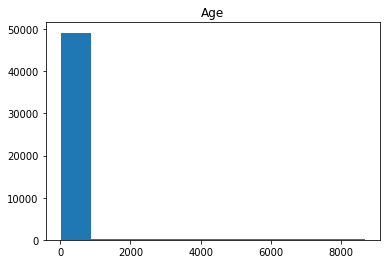

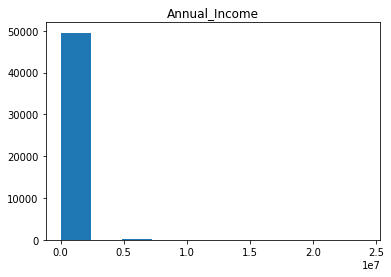

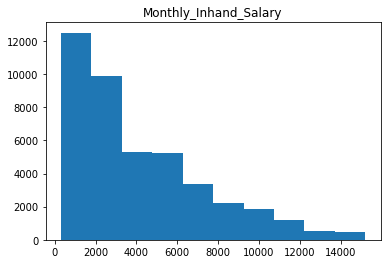

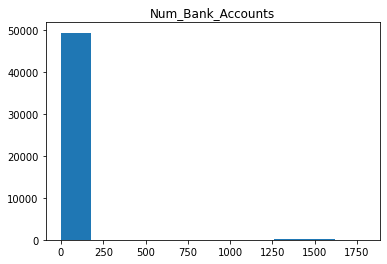

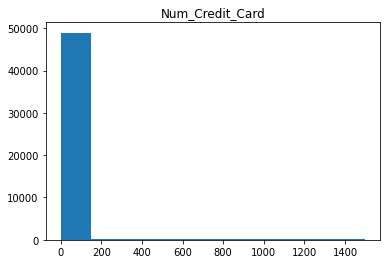

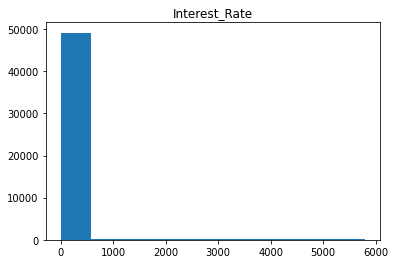

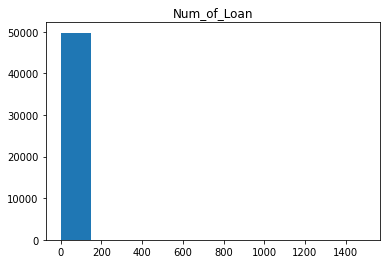

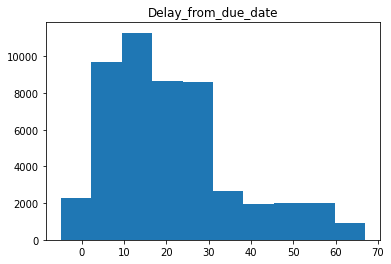

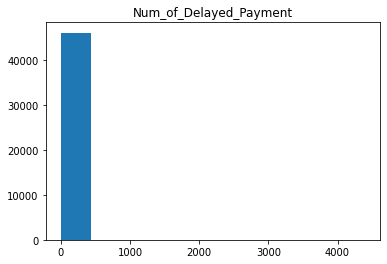

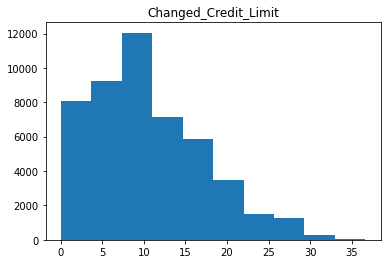

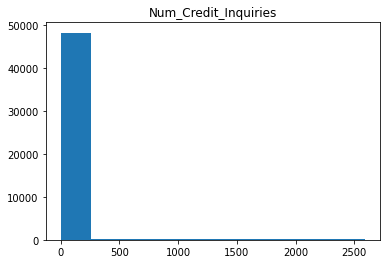

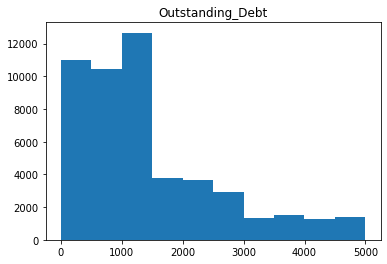

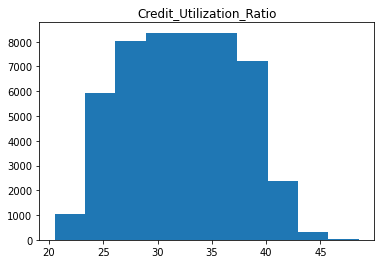

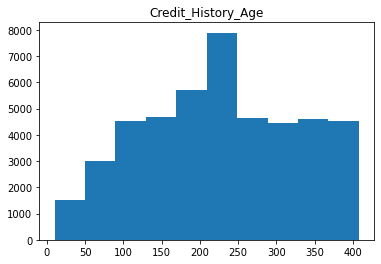

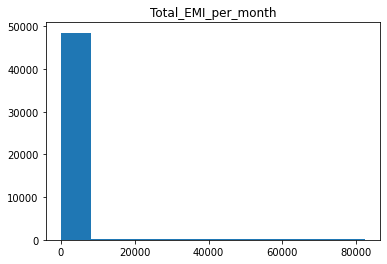

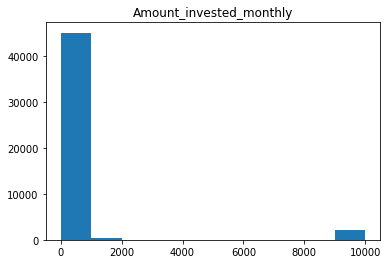

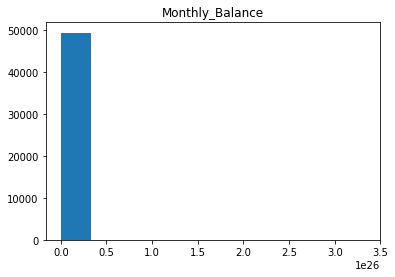

In [44]:
# Visualizing data distribution of each feature to spot outliers
for i in NumFeatures:
    plt.hist(test2[i])
    plt.title(i)
    plt.show()

Findings:
1. Monthly_Inhand_Salary, Num_of_Delayed_Payment, Changed_Credit_Limit, Num_Credit_Inquiries, Credit_History_Age, and Amount_invested_monthly, and Monthly_Balance features (total: 7 features) have missing values.
2. Age, Annual_Income, Num_Bank_Accounts, Num_Credit_Card, Interest_Rate, Num_of_Loan, Num_of_Delayed_Payment, Num_Credit_Inquiries, Total_EMI_per_month, Amount_invested_monthly, Monthly_Balance features (total: 11 features) have abnormal max value (upper outlier). These outliers should be addressed when we are filling in the missing values using mean +- stddev imputation method
3. Continuing from the Type_of_Loan feature data cleaning, the Num_of_Loan feature will need to be updated with reference to the updated value in Type_of_Loan. The Type_of_Loan feature itself will be dropped afterwards.

Important numerical data cleaning note:
In the numerical features data cleaning process, there might be cases in which each one needs a different approach. The cases:
1. Missing value in an independent entry
2. Missing value in one or more members of an aggregated entries
3. Different value in one or more members of an aggregated entries
4. Totally missing values of an aggregated entries

For example:
Customer A has 8 entries in the dataset. The Age value of this customer is either supposed to be the same in all 8 entries or differ with +1 value in the forward entries (assuming he/she might have had a birthday during the period of the data collection). However, when we are looking at the dataset, the Age values of this customer's entries show that they either have missing values or varying values. This kind of case needs to be made distinct from the other cases.

## **VII. Numerical Feature Engineering: Data Cleaning**

### **VIIa. Numerical Feature: Age**

The first thing we want to do with the Age feature is to get rid of the illogical values. Let us assume that the oldest people can get in this dataset and still have active credit activities are 90 years old and the youngest ones are 18 years old, based on the general legal age of 18 to be able to have a credit card. Thus, the value above 90 and below 18 will be omitted.

In [45]:
# Age with value larger than 90
sample1 =  (test2['Age'] > 90).sum()
population = len(test2['Age'])
percentage1 = sample1 / population

# Age with value smaller than 18
sample2 = (test2['Age'] < 18).sum()
percentage2 = sample2 / population

# report
print(' Age with value larger than 90  :', 
      sample1,
      ' ',
      '(', percentage1, '% )', '\n',
      'Age with value smaller than 18 :', 
      sample2,
      ' ',
      '(', percentage2, '% )')

 Age with value larger than 90  : 1403   ( 0.02806 % ) 
 Age with value smaller than 18 : 2504   ( 0.05008 % )


In [46]:
# Dropping Age value larger than 90 and smaller than 18
NewAge = []
for i in range(len(test2.Age)):
    if test2.Age[i] > 90 or test2.Age[i] < 18:
        NewAge.append(np.nan)
    else:
        NewAge.append(test2.Age[i])       
test2['Age'] = NewAge

We are now going to fill in the missing values which appeared because of the previous omission. It is important to differ the type of missing values in this feature. Each customer has 8 entries in the dataset. These 8 entries are supposed to have the same Age value or +1 Age value in the forward entries, considering that he or she might have had a birthday during the data collection period (however, for practicality purpose, we will be assuming the same Age value in all 8 entries for one customer instead). Taking this into consideration, we can not immediately fill in all of the missing values with Age median +- standard deviation. We need to first try filling in the missing values with each customer's mode first.

In [47]:
# Age lookup table, aggregated by customer ID

# Creating the dataframe containing Customer_ID and Age
AgeLookup = test2[['Customer_ID', 'Age']]

# Returning the Age mode of each customer
AgeLookup = AgeLookup.groupby('Customer_ID').agg(pd.Series.mode)

# Replacing the Age value of each customer with each one's Mode
test2['Age'] = test2['Customer_ID'].map(AgeLookup.Age)

With this replacement method, it is possible to generate Age value in type of a list for some customers. This is due to the possibility of those customers having two or three Age values which each has the same amount of occurence in their entries. We are going to eliminate these list values by using the first members of the lists instead.

In [48]:
# Eliminating any generated list values by using the first member of the list
NewAge = []
for i in range(len(test2.Age)):
    # for float type members
    if type(test2.Age[i]) == np.float64:
        NewAge.append(test2.Age[i])
    # for empty list members
    elif type(test2.Age[i]) == np.ndarray and len(test2.Age[i]) == 0:
        NewAge.append(np.nan)
    # for non-empty list members
    elif type(test2.Age[i]) == np.ndarray and len(test2.Age[i]) != 0:
        NewAge.append(test2.Age[i][1])
test2['Age'] = NewAge

In [49]:
# Reconverting the Age feature into float
test2['Age'].astype('float')

0        24.0
1        24.0
2        24.0
3        24.0
4        28.0
         ... 
49995    29.0
49996    25.0
49997    25.0
49998    25.0
49999    25.0
Name: Age, Length: 50000, dtype: float64

In [50]:
# Rechecking the missing values in Age feature
remaining = test2['Age'].isnull().sum()
print('Remaining Age missing values :', remaining)

Remaining Age missing values : 2484


There are still 5504 missing values in Age feature. We are now going to fill in these remaining missing values.

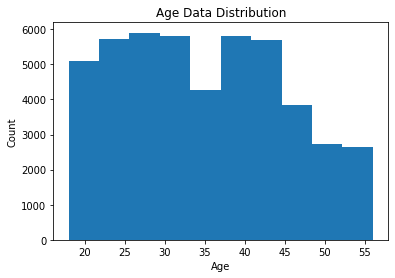

In [51]:
# Checking the Age data distribution
plt.hist(test2.Age)
plt.title('Age Data Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

The distribution looks good, distributed quite evenly. We then can fill in these remaining missing values with the mean +- standard deviation imputation.

In [52]:
# Age lookup table for remaining misisng values, aggregated by customer ID
table = test2[['Customer_ID', 'Age']]

# Locating the entries with empty Age value
Cust_ID = table.loc[table['Age'].isnull(), 'Customer_ID']

# Getting only the unique Customer_ID
Cust_ID = Cust_ID.unique()

# Transforming the Customer_ID with empty Age value into a list
Cust_ID = list(Cust_ID)

# Creating the empty Age feature
Age = []
for i in range(len(Cust_ID)):
    Age.append(np.nan)

# Creating the Age lookup table
AgeLookup = pd.DataFrame(list(zip(Cust_ID, Age)))
AgeLookup.columns = ['Customer_ID', 'Age']

# Mean of Age feature
AgeMean = test2.Age.mean()

# Standard deviation of Age feature
AgeStdDev = test2.Age.std()

# Generating the Age value for the AgeLookup table
AgeLookup['Age'] = AgeLookup['Age'].fillna(pd.Series(np.random.randint(int(AgeMean - AgeStdDev), 
                                                                       int(AgeMean + AgeStdDev),
                                                                       size = AgeLookup.Age.isnull().sum())))

In [53]:
# Filling in the missing Age values in reference to the AgeLookup table
test2['Age'] = test2['Age'].fillna(test2['Customer_ID'].map(AgeLookup.set_index('Customer_ID')['Age']))

# Checking if there are still missing Age values
test2['Age'].isnull().sum()

0

### **VIIb. Numerical Feature: Annual_ Income**

In [54]:
# restore point
test2['Annual_Income'] = test['Annual_Income']

By looking at the previous histogram, there exists some outliers in the Annual_Income feature as well, with upper outliers the most obvious. Luckily, there are no missing values. Let's deal with the outliers first.

In [55]:
# Counting the outliers in Annual_Income
countoutlier(test2, 'Annual_Income')

Outlier count in Annual_Income : 1390


Annual_Income  data distribution after dropping the outliers : 


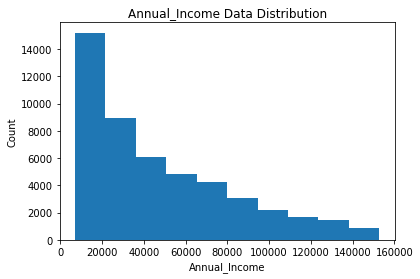

In [56]:
# Dropping the outliers in Annual_Income
omitoutlier(test2, 'Annual_Income')

The Annual_Income values per customer should share a same value, since the data collection only spans over a period of eight months. This is based on the assumption that each customer did not change occupation during the data collection period. For practicality purpose, the eight Annual_Income values per customer will share a same value.

The data cleaning operation for this feature is basically the same as the previous Age feature, but is now using some defined functions instead to make the process simpler.

In [57]:
# Replacing the Annual_Income value of each customer with each one's Mode
lookupreplacement(test2, 'Customer_ID', 'Annual_Income')

Remaining Annual_Income missing values : 896


There are still 1800 (or 225 customers) with totally missing Annual_Income values. We will fill in these missing values.

In [58]:
# Filling in the remaining Annual_Income missing values
aggregatedfillna(test2, 'Customer_ID', 'Annual_Income')

Remaining Annual_Income missing values : 0


### **VIIc. Numerical Feature: Monthly_Inhand_Salary**

By looking at the previous histogram, there does not seem to exist notable outliers. However, there are some missing values that need to be dealt with. Considering that the Monthly_Inhand_Salary values per customer should share a same value, we will be dealing with this feature using the defined lookupreplacement and aggregatedfillna functions.

In [59]:
# Replacing the Monthly_Inhand_Salary value of each customer with each one's Mode
lookupreplacement(test2, 'Customer_ID', 'Monthly_Inhand_Salary')

Remaining Monthly_Inhand_Salary missing values : 28


There are still 28 (or 7 customers) with totally missing Monthly_Inhand_Salary values. We will fill in these missing values.

In [60]:
# Filling in the remaining Annual_Income missing values
aggregatedfillna(test2, 'Customer_ID', 'Monthly_Inhand_Salary')

Remaining Monthly_Inhand_Salary missing values : 0


There are no remaining missing values after the lookupreplacement operation, so we will proceed with the next numerical feature.

### **VIId. Numerical Feature: Num_Bank_Accounts**

By looking at the previous histogram, there exists some outliers in the Num_Bank_Accounts feature, with upper outliers the most obvious. Luckily, there are no missing values. Let's deal with the outliers first.

In [61]:
# Counting the outliers in Num_Bank_Accounts
countoutlier(test2, 'Num_Bank_Accounts')

Outlier count in Num_Bank_Accounts : 635


Num_Bank_Accounts  data distribution after dropping the outliers : 


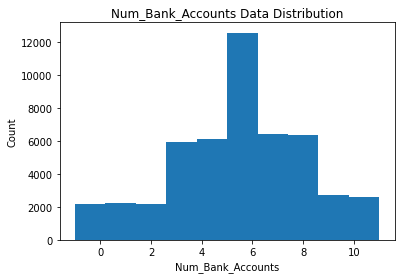

In [62]:
# Dropping the outliers in Num_Bank_Accounts
omitoutlier(test2, 'Num_Bank_Accounts')

The data distribution looks nice. Since the Num_Bank_Accounts values per customer share a same value, we will be dealing with this feature using the defined lookupreplacement and aggregatedfillna functions.

In [63]:
# Replacing the Num_Bank_Accounts value of each customer with each one's Mode
lookupreplacement(test2, 'Customer_ID', 'Num_Bank_Accounts')

Remaining Num_Bank_Accounts missing values : 0


There are no remaining missing values after the lookupreplacement operation, so we will proceed with the next numerical feature.

### **VIIe. Numerical Feature: Num_Credit_Card**

By looking at the previous histogram, there exists some outliers in the Num_Credit_Card feature, with upper outliers the most obvious. Luckily, there are no missing values. Let's deal with the outliers first.

In [64]:
# Counting the outliers in Num_Credit_Card
countoutlier(test2, 'Num_Credit_Card')

Outlier count in Num_Credit_Card : 1179


Num_Credit_Card  data distribution after dropping the outliers : 


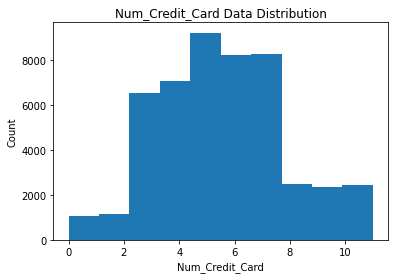

In [65]:
# Dropping the outliers in Num_Credit_Card
omitoutlier(test2, 'Num_Credit_Card')

The data distribution looks nice. Since the Num_Credit_Card values per customer share a same value, we will be dealing with this feature using the defined lookupreplacement and aggregatedfillna functions.

In [66]:
# Replacing the Num_Credit_Card value of each customer with each one's Mode
lookupreplacement(test2, 'Customer_ID', 'Num_Credit_Card')

Remaining Num_Credit_Card missing values : 0


There are no remaining missing values after the lookupreplacement operation, so we will proceed with the next numerical feature.

### **VIIf. Numerical Feature: Interest_Rate**

By looking at the previous histogram, there exists some outliers in the Interest_Rate feature, with upper outliers the most obvious. Luckily, there are no missing values. Let's deal with the outliers first.

In [67]:
# Counting the outliers in Interest_Rate
countoutlier(test2, 'Interest_Rate')

Outlier count in Interest_Rate : 966


Interest_Rate  data distribution after dropping the outliers : 


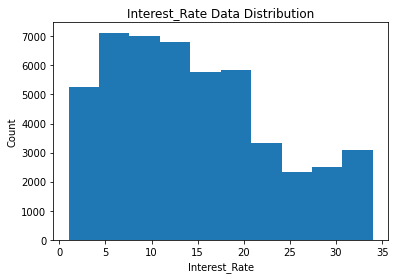

In [68]:
# Dropping the outliers in Interest_Rate
omitoutlier(test2, 'Interest_Rate')

The data distribution looks nice. Since the Interest_Rate values per customer share a same value, we will be dealing with this feature using the defined lookupreplacement and aggregatedfillna functions.

In [69]:
# Replacing the Interest_Rate value of each customer with each one's Mode
lookupreplacement(test2, 'Customer_ID', 'Interest_Rate')

Remaining Interest_Rate missing values : 0


There are no remaining missing values after the lookupreplacement operation, so we will proceed with the next numerical feature.

### **VIIg. Numerical Feature: Num_of_Loan**

The Num_of_Loan feature is dependent to the Type_of_Loan feature. Num_of_Loan is basically the count of loan types that are present in the Type_of_Loan feature. Therefore, we are going to replace the outliers and possibly any wrong values by the count of the previously cleaned Type_of_Loan feature.

In [70]:
# Creating a list to store the Type_of_Loan count of each row
Num_of_Loan = []

# Counting Type_of_Loan in each row and storing them in Num_of_Loan
for row in range(len(test2['Type_of_Loan'])):
    num = len(test2['Type_of_Loan'][row])
    Num_of_Loan.append(num)

# Replacing the Num_of_Loan feature with the new list
test2['Num_of_Loan'] = Num_of_Loan

# Dropping the Type_of_Loan feature since it's redundant
test2.drop('Type_of_Loan', axis = 1, inplace = True)

To make it more intuitive when further analyzing the data, we will move the Num_of_Loan feature just before the Type_of_Loan features.

In [71]:
# Moving the Num_of_Loan feature just before the now-spread Type_of_Loan features

# Temporarily storing the features as a list
cols = test2.columns.tolist() 

# Rearranging the features
cols = cols[:11] + cols[12:-10] + [cols[11]] + cols[-10:]
print(cols) # Checking if the order of the features

# Turning back the data into a dataframe
test2 = test2[cols]

['ID', 'Customer_ID', 'Month', 'Age', 'SSN', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Payment_Behaviour', 'Num_of_Loan', 'Monthly_Balance', 'Auto Loan', 'Credit-Builder Loan', 'Debt Consolidation Loan', 'Home Equity Loan', 'Mortgage Loan', 'Not Specified', 'Payday Loan', 'Personal Loan', 'Student Loan']


### **VIIh. Numerical Feature: Num_of_Delayed_Payment**

By looking at the previous histogram, there exists some outliers in the Num_of_Delayed_Payment feature, with upper outliers the most obvious. Luckily, there are no missing values. Let's deal with the outliers first.

In [72]:
# Counting the outliers in Num_of_Delayed_Payment
countoutlier(test2, 'Num_of_Delayed_Payment')

Outlier count in Num_of_Delayed_Payment : 395


Num_of_Delayed_Payment  data distribution after dropping the outliers : 


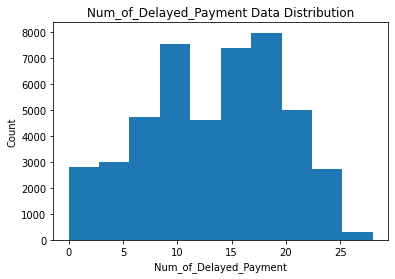

In [73]:
# Dropping the outliers in Num_of_Delayed_Payment
omitoutlier(test2, 'Num_of_Delayed_Payment')

The data distribution looks nice. In Num_of_Loan feature, the eight values shared by a customer does not necessarily have to be a same value. There are two ways to fill in the missing values, that is to simply change the nan values to 0 or using forward fill method. We will be using the later if there exists any 0 value in the feature, since the existence may imply that the nan value does not necessarily mean empty or zero. Forward fill method is one of the better ways to fill in this type of missing values to maintain the similarity between the values shared by each customer.

In [74]:
# Checking if there are any Num_of_Delayed_Payment with 0 value
(test2['Num_of_Delayed_Payment'] == 0).sum()

811

There exists the 0 values. Therefore, we will be using the forward fill method to fill in the missing values.

In [75]:
# Filling in the missing Num_of_Delayed_Payment values with forward fill method
test2['Num_of_Delayed_Payment'] = test2['Num_of_Delayed_Payment'].fillna(method = 'ffill')

# Checking if there are still missing values in the Num_of_Delayed_Payment feature
test2['Num_of_Delayed_Payment'].isnull().sum()

0

### **VIIi. Numerical Feature: Changed_Credit_Limit**

By looking at the previous histogram, there does not seem to exist notable outliers. However, there are some missing values that need to be dealt with. In Changed_Credit_Limit feature, the eight values shared by a customer does not necessarily have to be a same value. Same as before, we will be filling in the missing values by either changing the nan values to 0 method or using forward fill method.

In [76]:
test2['Changed_Credit_Limit'].isnull().sum()

1059

In [77]:
# Checking if there are any Changed_Credit_Limit with 0 value
(test2['Changed_Credit_Limit'] == 0).sum()

2

There exists the 0 values. Therefore, we will be using the forward fill method to fill in the missing values.

In [78]:
# Filling in the missing Changed_Credit_Limit values with forward fill method
test2['Changed_Credit_Limit'] = test2['Changed_Credit_Limit'].fillna(method = 'ffill')

# Checking if there are still missing values in the Changed_Credit_Limit feature
test2['Changed_Credit_Limit'].isnull().sum()

0

### **VIIj. Numerical Feature: Num_Credit_Inquiries**

In [79]:
# Counting the outliers in Num_Credit_Inquiries
countoutlier(test2, 'Num_Credit_Inquiries')

Outlier count in Num_Credit_Inquiries : 846


Num_Credit_Inquiries  data distribution after dropping the outliers : 


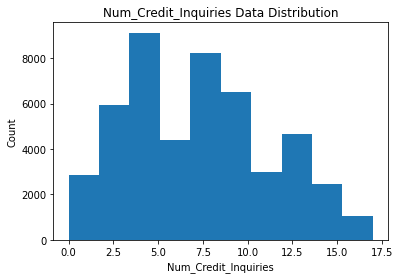

In [80]:
# Dropping the outliers in Num_Credit_Inquiries
omitoutlier(test2, 'Num_Credit_Inquiries')

The data distribution looks nice. In Num_Credit_Inquiries feature, the eight values shared by a customer does not necessarily have to be a same value. Same as before, we will be filling in the missing values by either changing the nan values to 0 method or using forward fill method.

In [81]:
# Checking if there are any Num_Credit_Inquiries with 0 value
(test2['Num_Credit_Inquiries'] == 0).sum()

1102

There exists the 0 values. Therefore, we will be using the forward fill method to fill in the missing values.

In [82]:
# Filling in the missing Num_Credit_Inquiries values with forward fill method
test2['Num_Credit_Inquiries'] = test2['Num_Credit_Inquiries'].fillna(method = 'ffill')

# Checking if there are still missing values in the Num_Credit_Inquiries feature
test2['Num_Credit_Inquiries'].isnull().sum()

1

There is still one missing value in this feature. It probably is the first entry of the dataset. Let's check if it is true.

In [83]:
# Checking the location of the last missing value
test2.loc[test2['Num_Credit_Inquiries'].isnull()]

,ID,Customer_ID,Month,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Num_of_Loan,Monthly_Balance,Auto Loan,Credit-Builder Loan,Debt Consolidation Loan,Home Equity Loan,Mortgage Loan,Not Specified,Payday Loan,Personal Loan,Student Loan
0,0x160a,CUS_0xd40,September,24.0,821-00-0265,Scientist,19114.12,1824.843333,3.0,4.0,3.0,3,7.0,11.27,NaN,Good,809.98,35.030402,273.0,No,49.574949,236.642682,Low_spent_Small_value_payments,4,186.266702,True,True,False,True,False,False,False,True,False


It is true that the last missing value presents itself in the first entry of the dataset. We will be filling in this missing value using backward fill method, the counterpart of the previously used forward fill method.

In [84]:
# Filling in the missing Num_Credit_Inquiries values with forward fill method
test2['Num_Credit_Inquiries'] = test2['Num_Credit_Inquiries'].fillna(method = 'bfill')

# Checking if there are still missing values in the Num_Credit_Inquiries feature
test2['Num_Credit_Inquiries'].isnull().sum()

0

### **VIIk. Numerical Feature: Credit_History_Age**

By looking at the previous histogram, there does not seem to exist notable outliers. However, there are some missing values that need to be dealt with. In Credit_History_Age feature, the eight values shared by a customer does not necessarily have to be a same value. In fact, the values shared by each customer act differently compared to the values in other features.

In [85]:
# Creating a list containing index with step 4 to locate the start of each customer
# range start
start = 0
# range stop: the number of the entries
stop = len(test2)
# range step: the number of entries for each customer
step = len(test2[test2['Customer_ID'] == test2['Customer_ID'].unique()[0]])
# Defining CustomerIndexer
CustomerIndexer = range(start, stop, step)

# Start of the moving index
i = 0

# Iterating through each customer to fill the missing values
for indexstart, ID in zip(CustomerIndexer, test2['Customer_ID'].unique()):
    
    # Dealing with the first n missing values
    
    i = indexstart # Index start for each new customer
    
    # While the beginning entry of the current customer is still empty
    while i > -1 and np.isnan(test2['Credit_History_Age'][indexstart]) == True:
        if np.isnan(test2['Credit_History_Age'][i]) == True: # Encountering missing value
            i = i + 1
        else: # Encountering filled entry
            test2['Credit_History_Age'][i - 1] = test2['Credit_History_Age'][i] - 1
            i = i - 1
    
    # Dealing with the rest of the missing values
    
    i = indexstart # Restarting the loop from the current customer's first entry
    
    # While i is still in bound and the Customer_ID is according to the current cuustomer
    while i < len(test2['Customer_ID']) and test2['Customer_ID'][i] == ID:
        if np.isnan(test2['Credit_History_Age'][i]) == False: # Encountering filled entry
            i = i + 1
        else: # Encountering missing value
            test2['Credit_History_Age'][i] = test2['Credit_History_Age'][i - 1] + 1
            i = i + 1

# Checking if there are still missing values in the Credit_History_Age feature
test2['Credit_History_Age'].isnull().sum()

0

### **VIIl. Numerical Feature: Total_EMI_per_month**

By looking at the previous histogram, there exists some outliers in the Num_of_Loan feature, with upper outliers the most obvious. Luckily, there are no missing values. Let's deal with the outliers first.

In [86]:
# Counting the outliers in Total_EMI_per_month
countoutlier(test2, 'Total_EMI_per_month')

Outlier count in Total_EMI_per_month : 3933


Total_EMI_per_month  data distribution after dropping the outliers : 


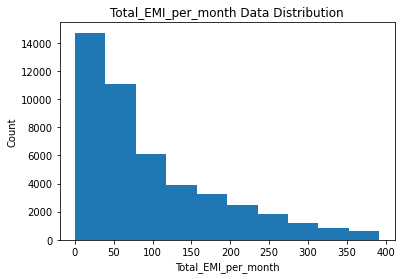

In [87]:
# Dropping the outliers in Total_EMI_per_month
omitoutlier(test2, 'Total_EMI_per_month')

The data distribution looks nice. Since the Total_EMI_per_month values per customer share a same value, we will be dealing with this feature using the defined lookupreplacement and aggregatedfillna functions.

In [88]:
# Replacing the Total_EMI_per_month value of each customer with each one's Mode
lookupreplacement(test2, 'Customer_ID', 'Total_EMI_per_month')

Remaining Total_EMI_per_month missing values : 2148


There are still 2376 (or 297 customers) with totally missing Total_EMI_per_month values. We will fill in these missing values.

In [89]:
# Filling in the remaining Total_EMI_per_month missing values
aggregatedfillna(test2, 'Customer_ID', 'Total_EMI_per_month')

Remaining Total_EMI_per_month missing values : 0


### **VIIm. Numerical Feature: Amount_invested_monthly**

In [90]:
# Counting the outliers in Amount_invested_monthly
countoutlier(test2, 'Amount_invested_monthly')

Outlier count in Amount_invested_monthly : 5035


Amount_invested_monthly  data distribution after dropping the outliers : 


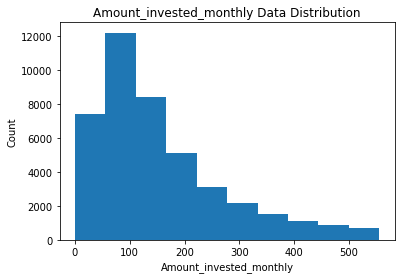

In [91]:
# Dropping the outliers in Amount_invested_monthly
omitoutlier(test2, 'Amount_invested_monthly')

In [92]:
# Checking the remaining missing values
test2['Amount_invested_monthly'].isnull().sum()

7306

Let's fill in the missing values using the aggregatedfillna defined function since the eight values shared by each customer do not necessarily have to be a same value.

In [93]:
# Filling in the remaining Amount_invested_monthly missing values
aggregatedfillna(test2, 'Customer_ID', 'Amount_invested_monthly')

Remaining Amount_invested_monthly missing values : 0


### **VIIn. Numerical Feature: Monthly_Balance**

In [94]:
# Counting the outliers in Monthly_Balance
countoutlier(test2, 'Monthly_Balance')

Outlier count in Monthly_Balance : 3838


Monthly_Balance  data distribution after dropping the outliers : 


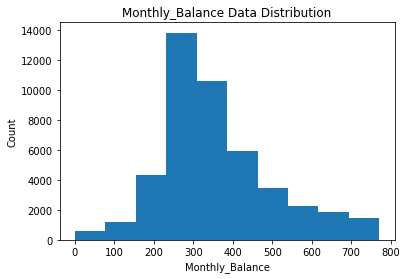

In [95]:
# Dropping the outliers in Monthly_Balance
omitoutlier(test2, 'Monthly_Balance')

Assuming that it is not very likely for people to have zero monthly balance, we are going to fill in the missing values in this feature with mean +- standard deviation method.

In [96]:
aggregatedfillna(test2, 'Customer_ID', 'Monthly_Balance')

Remaining Monthly_Balance missing values : 0


## **VIII. Finishing**

Now that we have pretty much finished with the test dataset data cleaning, let's do a final check before exporting the result into a new file.

### **VIIIa. Rechecking the dataset**

In [97]:
# dataset overview
test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        50000 non-null  object 
 1   Customer_ID               50000 non-null  object 
 2   Month                     50000 non-null  object 
 3   Age                       50000 non-null  float64
 4   SSN                       50000 non-null  object 
 5   Occupation                50000 non-null  object 
 6   Annual_Income             50000 non-null  float64
 7   Monthly_Inhand_Salary     50000 non-null  float64
 8   Num_Bank_Accounts         50000 non-null  float64
 9   Num_Credit_Card           50000 non-null  float64
 10  Interest_Rate             50000 non-null  float64
 11  Delay_from_due_date       50000 non-null  int64  
 12  Num_of_Delayed_Payment    50000 non-null  float64
 13  Changed_Credit_Limit      50000 non-null  float64
 14  Num_Cr

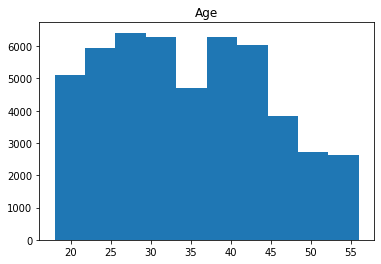

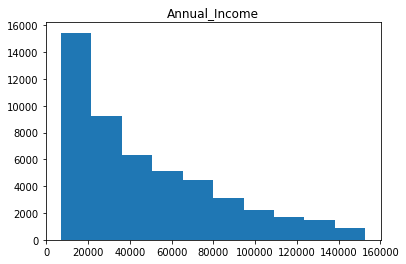

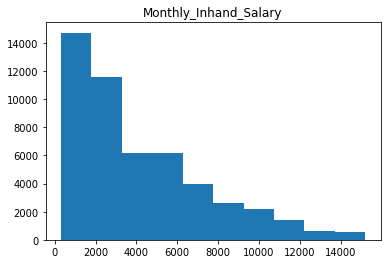

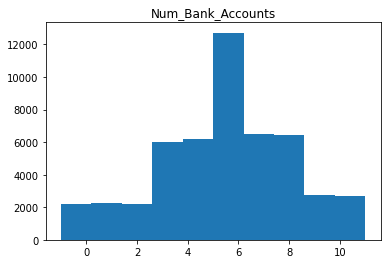

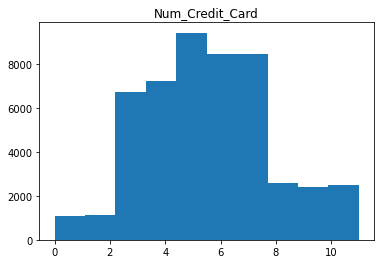

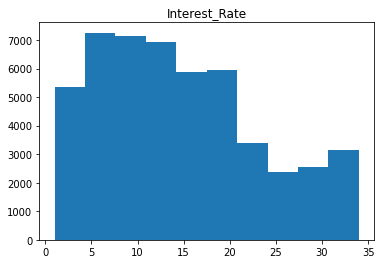

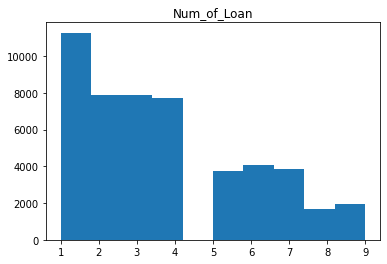

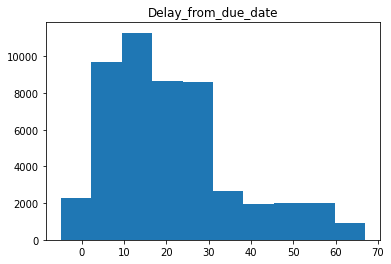

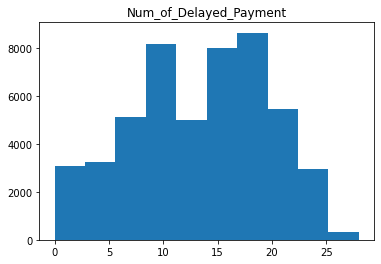

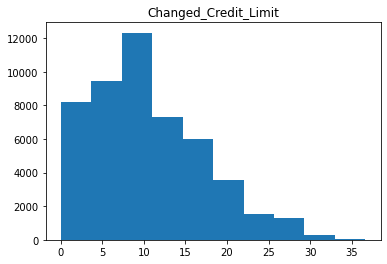

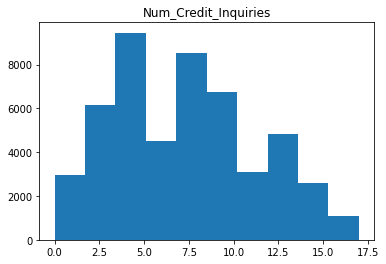

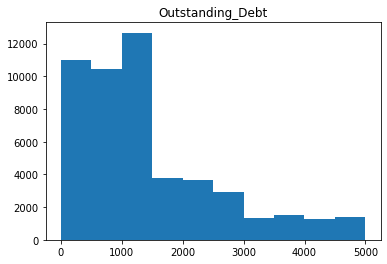

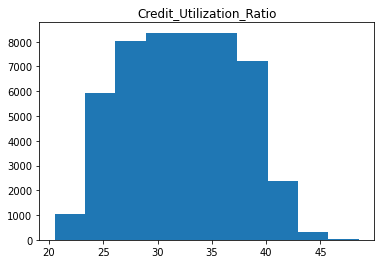

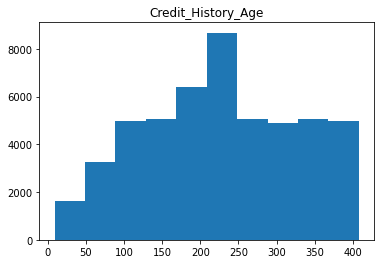

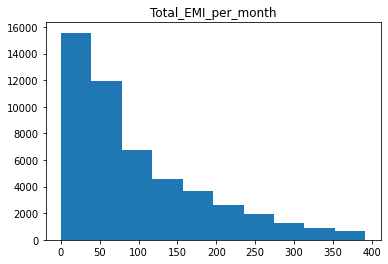

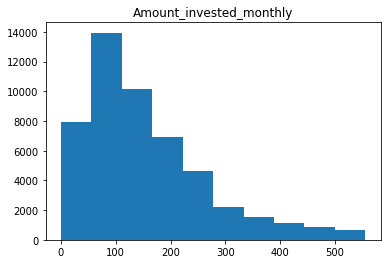

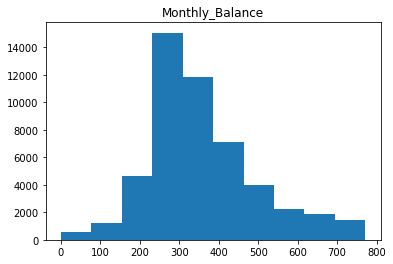

In [98]:
# Data distribution of each numerical feature
for i in NumFeatures:
    plt.hist(test2[i])
    plt.title(i)
    plt.show()

There are no missing values now and no notable extreme outliers present in the dataset. Any further data distribution engineering will take place in the next data analysis, with method tentative to the analysis method used when analyzing the data.

### **VIIIb. Exporting the dataset**

We are now done. What is left is to export the result of this data cleaning project to a csv file for further analysis.

In [100]:
test2.to_csv('Credit Score Classification (Cleaned Test Dataset).csv')